FINALLY got it working, so now its just cleaned up & will implement for various deltas/selections/POIs. Keeping the other one again becuse the progress/info could be helpful.

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util_splitdelta as gu
import plot_util as pu

from scipy.interpolate import interp1d

import Week7_PFNutils as W

import convert_sets_splitdelta as cs

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

2021-08-17 17:55:44.663625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 17:55:51.400813: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-17 17:55:51.419332: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-17 17:55:51.524481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-17 17:55:51.524522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 17:55:51.544832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [3]:
import vector as v

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

v.register_awkward()

In [4]:
events = ur.open(model_path+'delta_medium.root')

tree = events['EventTree']

In [5]:
truthID = tree['truthPartPdgId'].array()

In [13]:
def makemask(truthID, deltaID, excludeID, POI, partID2):
    #have to specify 4 particles: the delta of interest, what to avoid, the particle of interest that will later
    #be used, and then the other one 
    
    selectedinds = []    

    for i in range(len(truthID)): #basically: delta+, two categories: pip & n (without any ps) vs pi0 & p (no ns)
        if (deltaID in truthID[i]) & ~(excludeID in truthID[i]) & (POI in truthID[i]) & (partID2 in truthID[i]):
            selectedinds.append(i)

    flag = np.zeros(len(truthID))
    flag[selectedinds] = 2
    
    mask = flag == 2
    
    return mask

In [7]:
mask = makemask(truthID, 2214, 2212, 2112, 211) #delta+, no ps, POI = n, also pi+s

In [8]:
#cs.doit_cc(mask, data_path+'w12_closestcluster', 211, 2112)

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 211
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster


In [9]:
#then do data processing:
file = np.load(data_path+'w12_closestcluster.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

In [18]:
len(X)

7357

In [19]:
#W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster.npz', 7357)

In [7]:
NNfile = np.load(data_path+'nn_closestcluster.npz')
model_nog = tf.keras.models.load_model(model_path+'w8_pfn_noglob_2.hdf5')

2021-08-04 11:16:43.183814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-04 11:16:43.203660: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2021-08-04 11:16:43.312642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-04 11:16:43.914701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


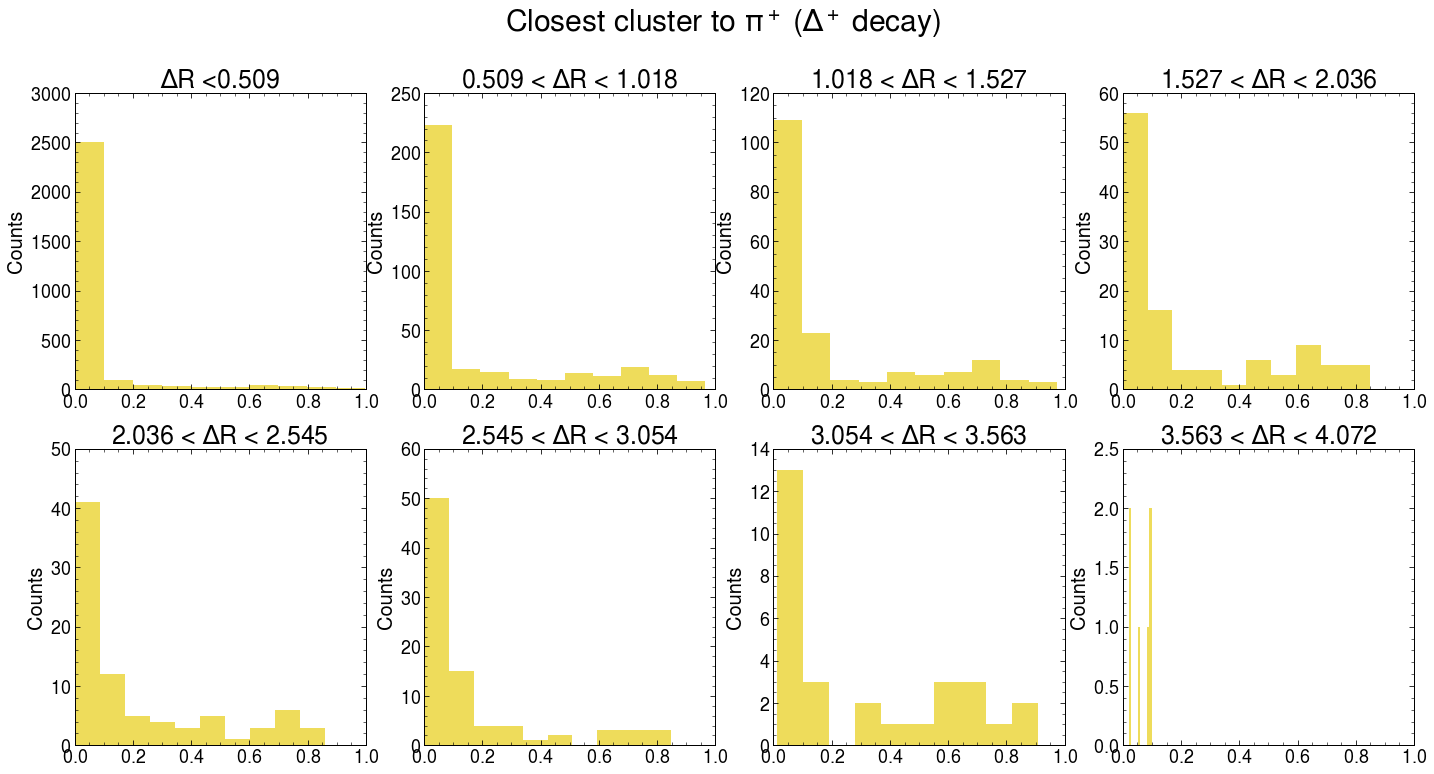

In [8]:
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:dull yellow', CC='Closest cluster to $\pi^+$ ($\Delta^+$ decay)') #delta+, no ps, POI = n, also pi+s

In [22]:
mask_0p = makemask(truthID, 2214, 2112, 2212, 111) #delta+, no ns, POI = pi0, also ps

In [24]:
#cs.doit_cc(mask_0p, data_path+'w12_closestcluster_pi0', 111, 2212)

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_pi0


In [25]:
#then do data processing:
file0 = np.load(data_path+'w12_closestcluster_pi0.npz')

X0 = file0['X']
clus_eta0 = file0['clus_eta']
clus_pt0 = file0['clus_pt']
clus_E0 = file0['clus_e']
clus_et0 = file0['clus_e_t']
deltar0 = file0['deltaR']

In [26]:
len(X0)

15385

In [27]:
#W.datatofile((X0, clus_eta0, clus_pt0, clus_E0, clus_et0, deltar0), 'nn_closestcluster_pi0.npz', len(X0))

In [9]:
NNfile0 = np.load(model_path+'nn_closestcluster_pi0.npz')

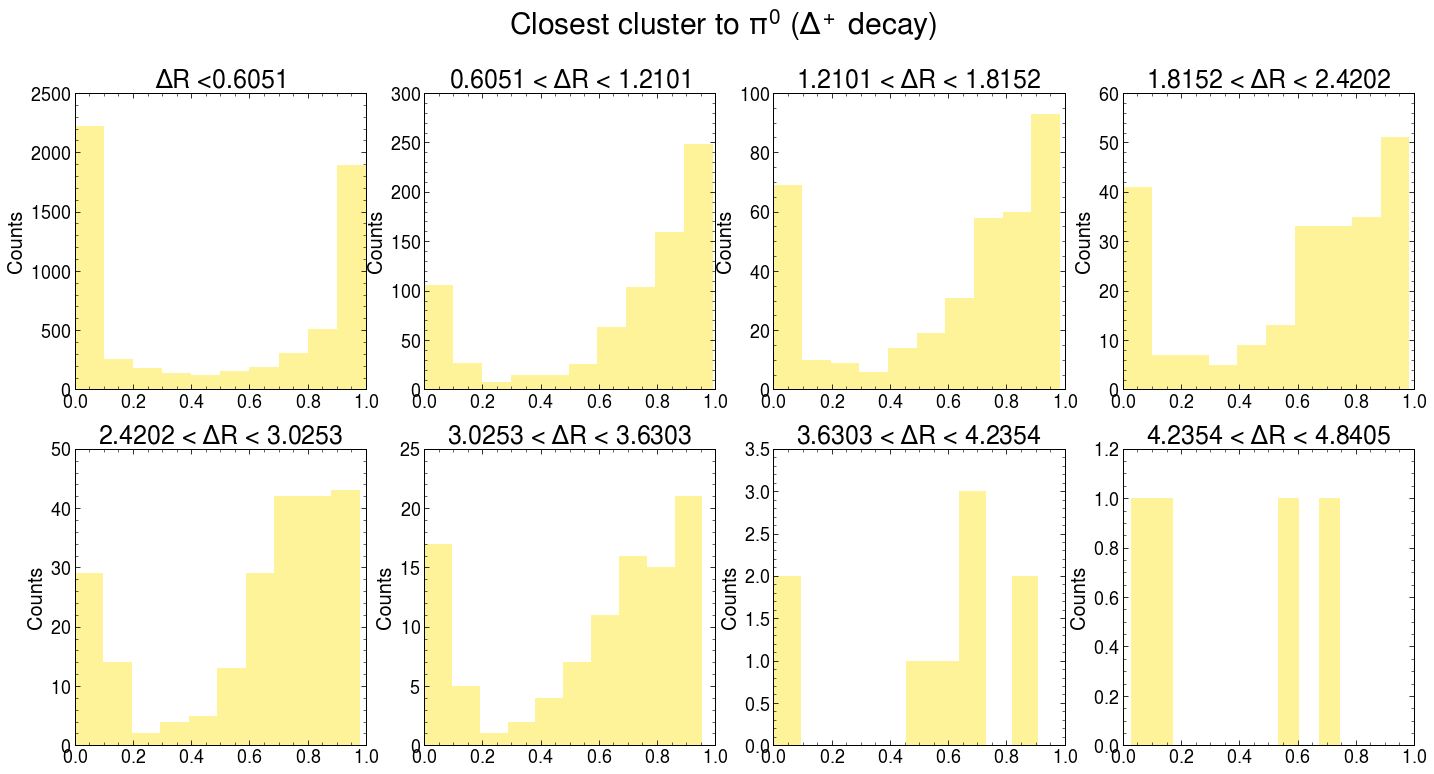

In [10]:
W.deltaR_responseplots(NNfile0, model_nog, col='xkcd:dark cream', CC='Closest cluster to $\pi^0$ ($\Delta^+$ decay)') #delta+, no ns, POI = pi0, also ps

In [14]:
# try for delta0??
mask_del0 = makemask(truthID, 2114, 2112, 2212, -211) #delta0, no ns, POI = pi-, also ps

#cs.doit_cc(mask_del0, data_path+'w12_closestcluster_del0pi-', -211, 2212)

#then do data processing:
filed0 = np.load(data_path+'w12_closestcluster_del0pi-.npz')

Xd0 = filed0['X']
clus_etad0 = filed0['clus_eta']
clus_ptd0 = filed0['clus_pt']
clus_Ed0 = filed0['clus_e']
clus_etd0 = filed0['clus_e_t']
deltard0 = filed0['deltaR']

#W.datatofile((Xd0, clus_etad0, clus_ptd0, clus_Ed0, clus_etd0, deltard0), 'nn_closestcluster_del0pi-.npz', len(Xd0))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle -211
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster_del0pi-


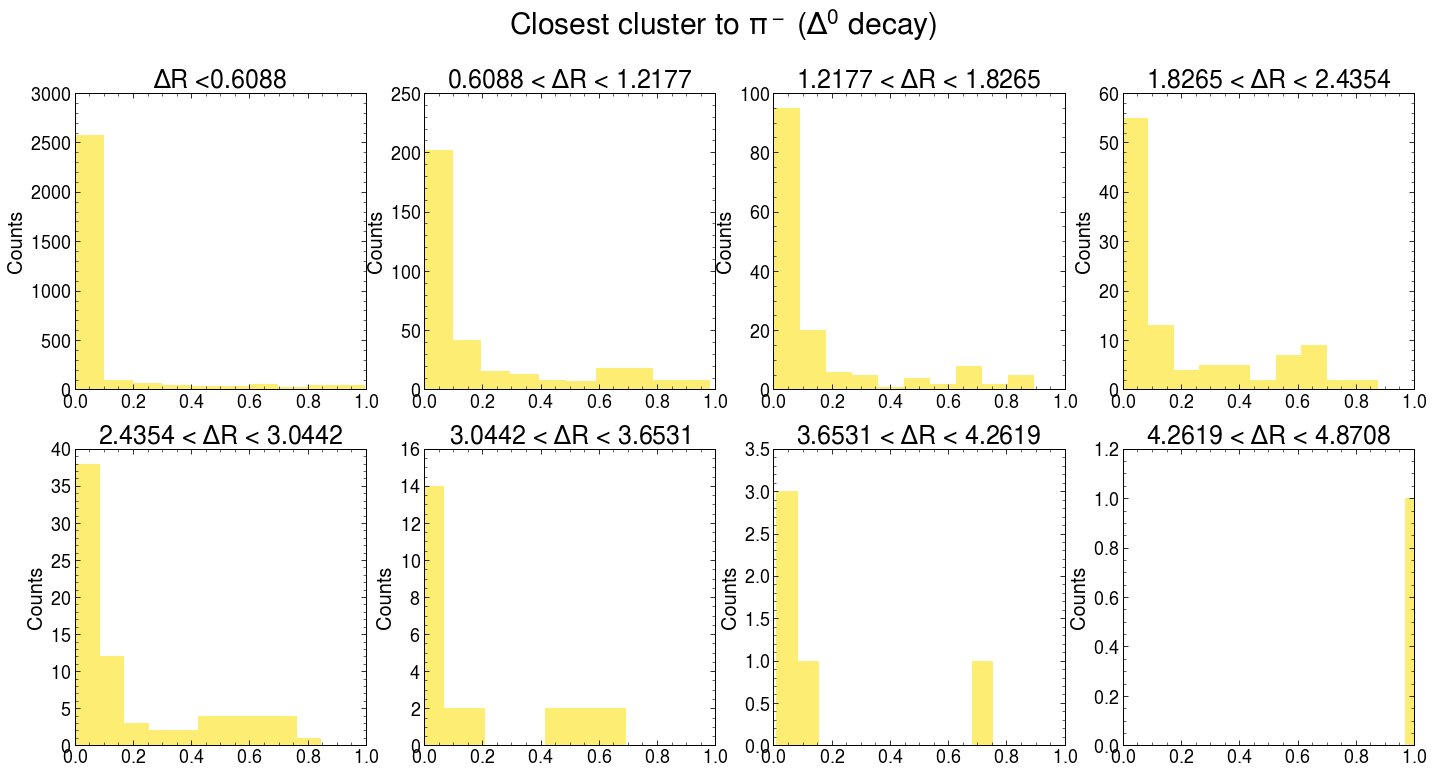

In [11]:
NNfiled0 = np.load(model_path+'nn_closestcluster_del0pi-.npz')
W.deltaR_responseplots(NNfiled0, model_nog, col='xkcd:sandy yellow', CC='Closest cluster to $\pi^-$ ($\Delta^0$ decay)') #delta0, no ns, POI = pi-, also ps

In [16]:
mask_del0p0 = makemask(truthID, 2114, 2212, 2112, 111) #delta0, no ps, POI = pi0, also ns

#cs.doit_cc(mask_del0p0, data_path+'w12_closestcluster_del0pi0', 111, 2112)

#then do data processing:
filed0p0 = np.load(data_path+'w12_closestcluster_del0pi0.npz')

Xd0p0 = filed0p0['X']
clus_etad0p0 = filed0p0['clus_eta']
clus_ptd0p0 = filed0p0['clus_pt']
clus_Ed0p0 = filed0p0['clus_e']
clus_etd0p0 = filed0p0['clus_e_t']
deltard0p0 = filed0p0['deltaR']

#W.datatofile((Xd0p0, clus_etad0p0, clus_ptd0p0, clus_Ed0p0, clus_etd0p0, deltard0p0), 'nn_closestcluster_del0pi0.npz', len(Xd0p0))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_del0pi0


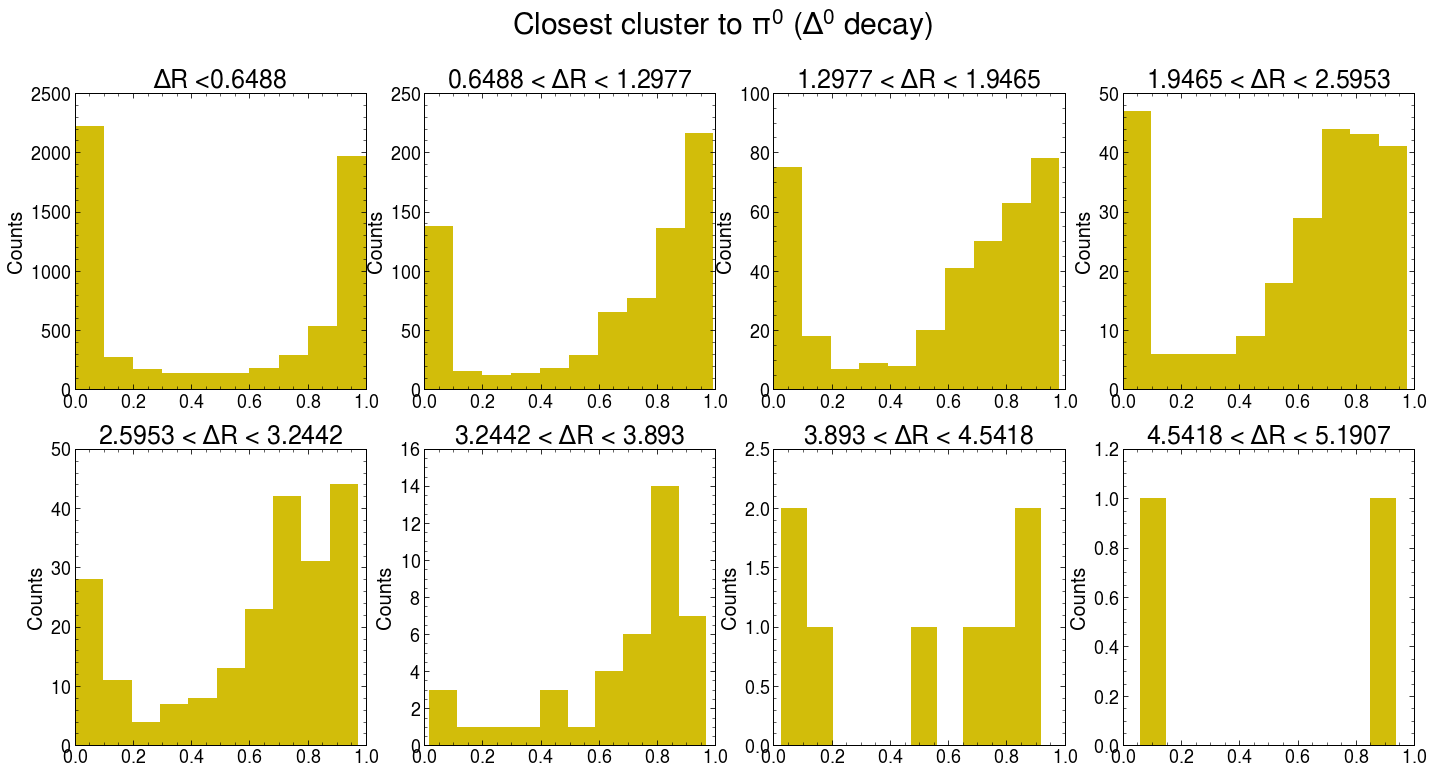

In [12]:
NNfiled0p0 = np.load(model_path+'nn_closestcluster_del0pi0.npz')
W.deltaR_responseplots(NNfiled0p0, model_nog, col='xkcd:mustard yellow', CC='Closest cluster to $\pi^0$ ($\Delta^0$ decay)') #delta0, no ps, POI = pi0, also ns

In [13]:
mask_Adel0pp = makemask(truthID, -2114, -2112, -2212, 211) #anti-delta0, no anti-ns, POI = pi+, also anti-ps

cs.doit_cc(mask_Adel0pp, data_path+'w12_closestcluster_Adel0pip', 211, -2212)

#then do data processing:
fileAd0pp = np.load(data_path+'w12_closestcluster_Adel0pip.npz')

XAd0pp = fileAd0pp['X']
clus_etaAd0pp = fileAd0pp['clus_eta']
clus_ptAd0pp = fileAd0pp['clus_pt']
clus_EAd0pp = fileAd0pp['clus_e']
clus_etAd0pp = fileAd0pp['clus_e_t']
deltarAd0pp = fileAd0pp['deltaR']

W.datatofile((XAd0pp, clus_etaAd0pp, clus_ptAd0pp, clus_EAd0pp, clus_etAd0pp, deltarAd0pp), 'nn_closestcluster_Adel0pip.npz', len(XAd0pp))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 211
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster_Adel0pip


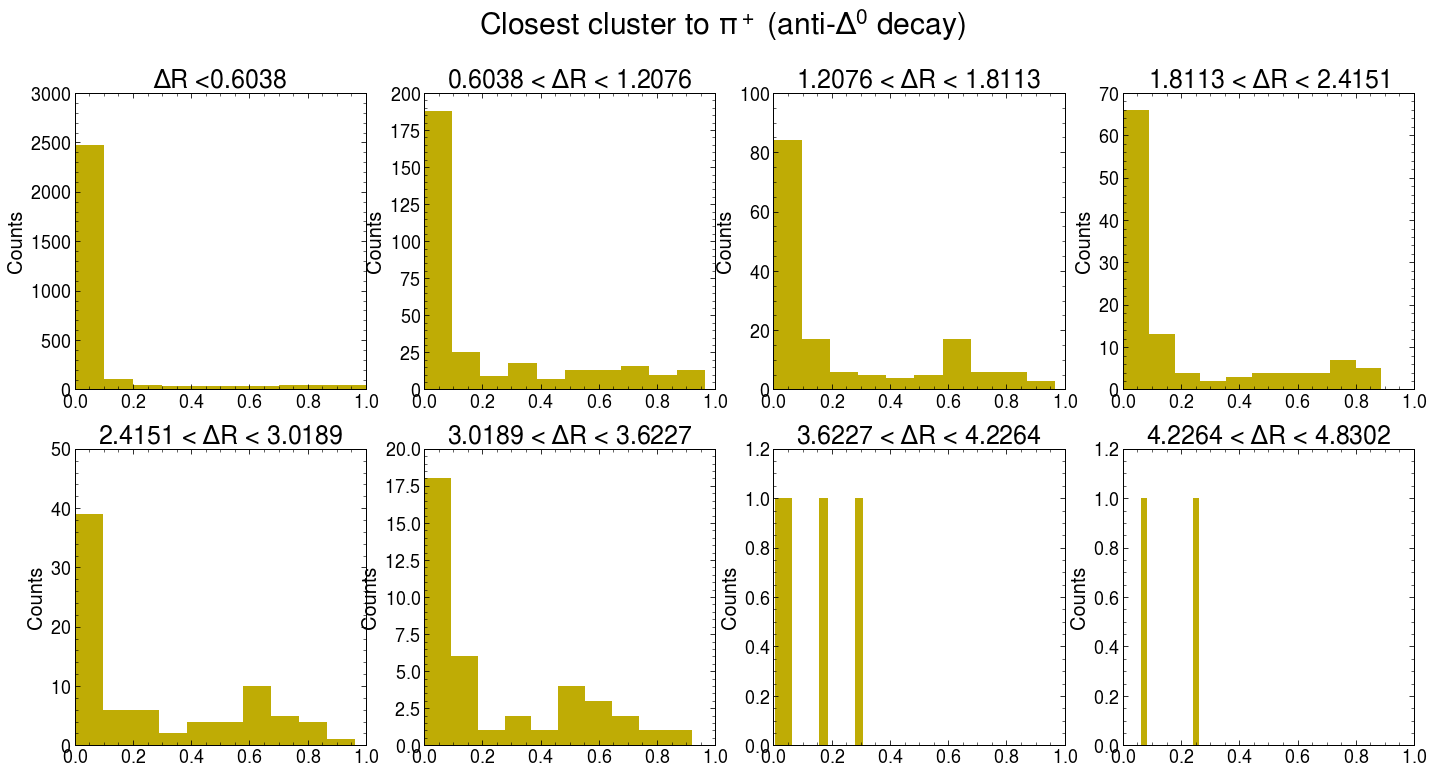

In [13]:
NNfileAd0pp = np.load(model_path+'nn_closestcluster_Adel0pip.npz')
W.deltaR_responseplots(NNfileAd0pp, model_nog, col='xkcd:muddy yellow', CC='Closest cluster to $\pi^+$ (anti-$\Delta^0$ decay)') #anti-delta0, no anti-ns, POI = pi+, also anti-ps

In [15]:
mask_Adel0p0 = makemask(truthID, -2114, -2212, -2112, 111) #anti-delta0, no anti-ps, POI = pi0, also anti-ns

cs.doit_cc(mask_Adel0p0, data_path+'w12_closestcluster_Adel0pi0', 111, -2112)

#then do data processing:
fileAd0p0 = np.load(data_path+'w12_closestcluster_Adel0pi0.npz')

XAd0p0 = fileAd0p0['X']
clus_etaAd0p0 = fileAd0p0['clus_eta']
clus_ptAd0p0 = fileAd0p0['clus_pt']
clus_EAd0p0 = fileAd0p0['clus_e']
clus_etAd0p0 = fileAd0p0['clus_e_t']
deltarAd0p0 = fileAd0p0['deltaR']

W.datatofile((XAd0p0, clus_etaAd0p0, clus_ptAd0p0, clus_EAd0p0, clus_etAd0p0, deltarAd0p0), 'nn_closestcluster_Adel0pi0.npz', len(XAd0p0))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_Adel0pi0


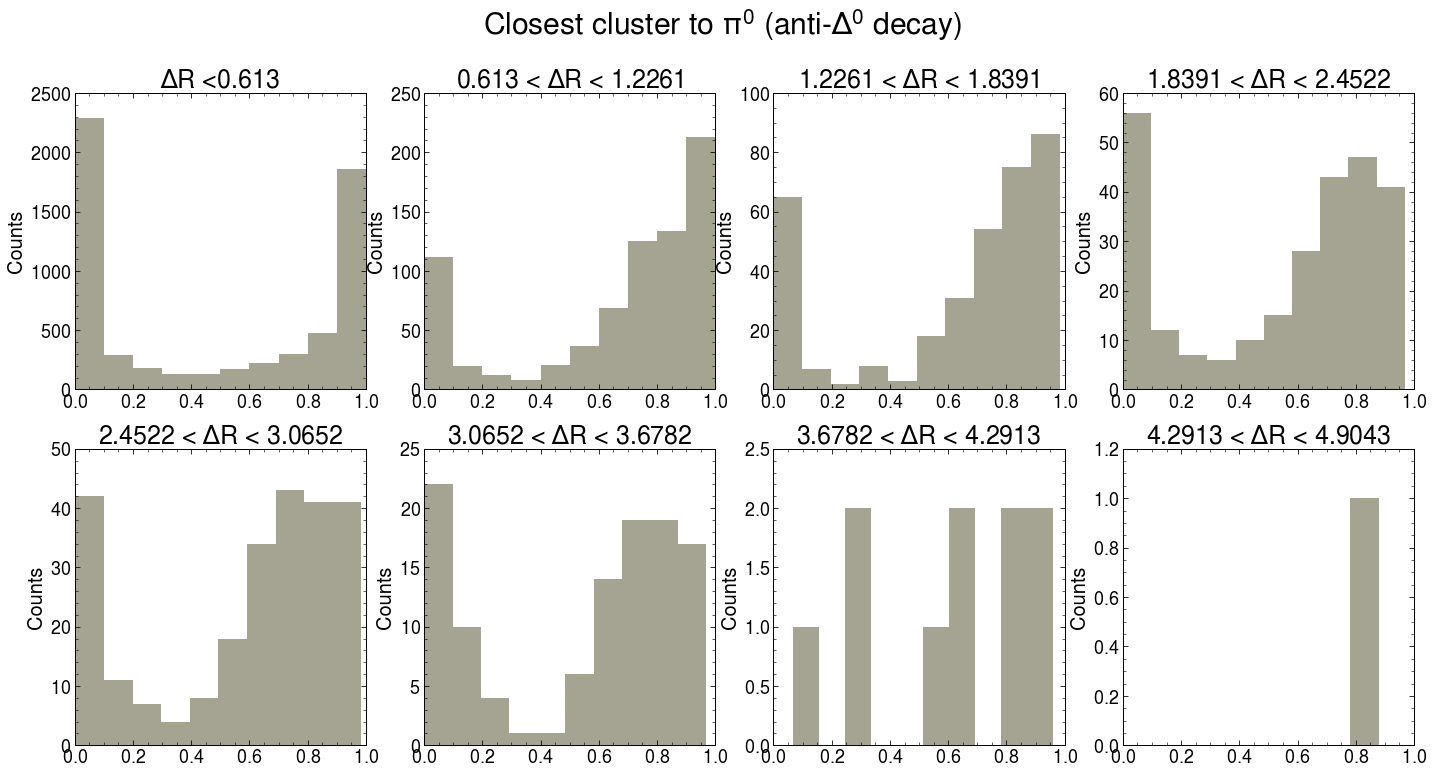

In [22]:
NNfileAd0p0 = np.load(model_path+'nn_closestcluster_Adel0pi0.npz')
W.deltaR_responseplots(NNfileAd0p0, model_nog, col='xkcd:cement', CC='Closest cluster to $\pi^0$ (anti-$\Delta^0$ decay)') #anti-delta0, no anti-ps, POI = pi0, also anti-ns

In [17]:
#finally for anti-delta+:
mask_Adelppm = makemask(truthID, -2214, -2212, -2112, -211) #anti-delta+, no anti-ps, POI = pi-, also anti-ns

cs.doit_cc(mask_Adelppm, data_path+'w12_closestcluster_Adelppim', -211, -2112)

#then do data processing:
fileAdppm = np.load(data_path+'w12_closestcluster_Adelppim.npz')

XAdppm = fileAdppm['X']
clus_etaAdppm = fileAdppm['clus_eta']
clus_ptAdppm = fileAdppm['clus_pt']
clus_EAdppm = fileAdppm['clus_e']
clus_etAdppm = fileAdppm['clus_e_t']
deltarAdppm = fileAdppm['deltaR']

W.datatofile((XAdppm, clus_etaAdppm, clus_ptAdppm, clus_EAdppm, clus_etAdppm, deltarAdppm), 'nn_closestcluster_Adelppim.npz', len(XAdppm))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle -211
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_Adelppim


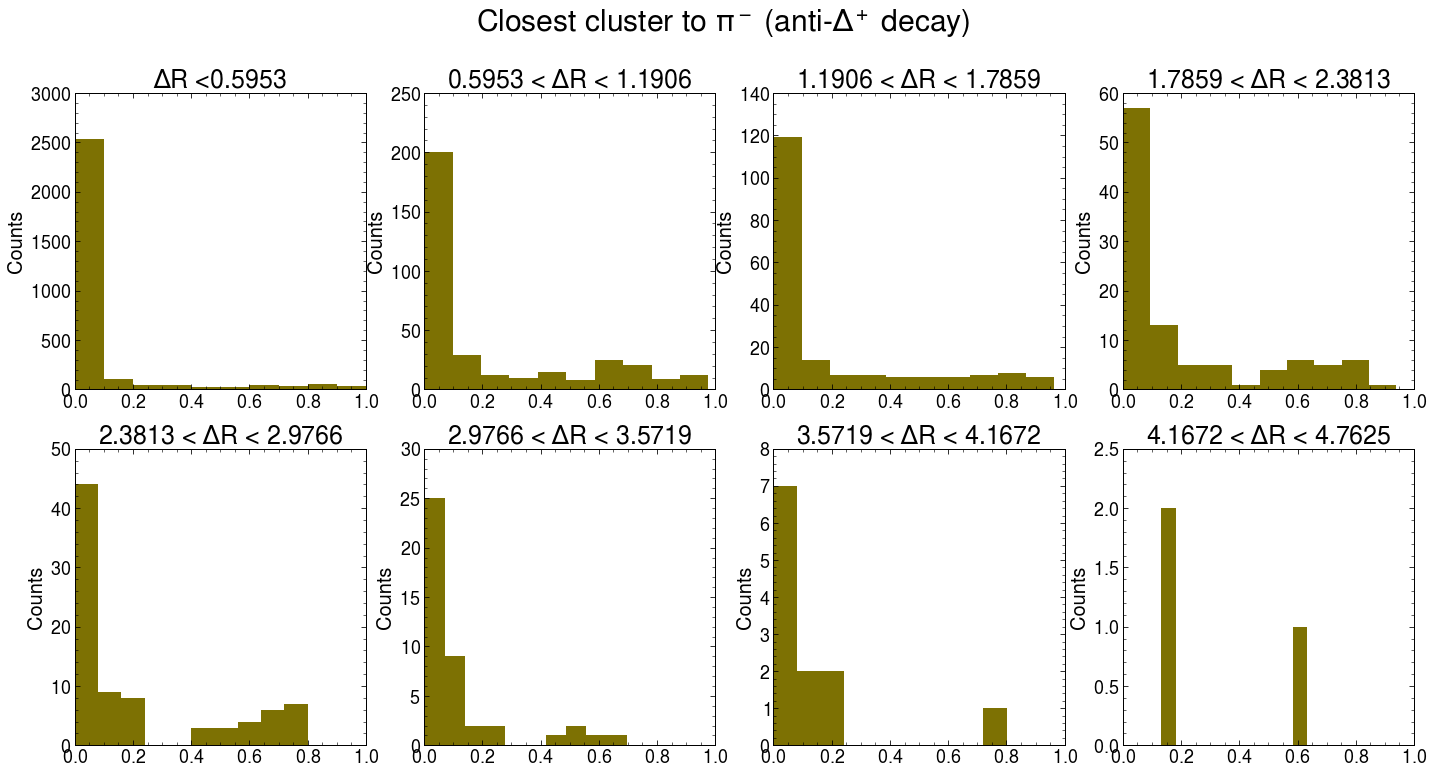

In [15]:
NNfileAdppm = np.load(model_path+'nn_closestcluster_Adelppim.npz')
W.deltaR_responseplots(NNfileAdppm, model_nog, col='xkcd:ugly brown', CC='Closest cluster to $\pi^-$ (anti-$\Delta^+$ decay)') #anti-delta+, no anti-ps, POI = pi-, also anti-ns

In [19]:
mask_Adelpp0 = makemask(truthID, -2214, -2112, -2212, 111) #anti-delta+, no anti-ns, POI = pi0, also anti-ps

cs.doit_cc(mask_Adelpp0, data_path+'w12_closestcluster_Adelppi0', 111, -2212)

#then do data processing:
fileAdpp0 = np.load(data_path+'w12_closestcluster_Adelppi0.npz')

XAdpp0 = fileAdpp0['X']
clus_etaAdpp0 = fileAdpp0['clus_eta']
clus_ptAdpp0 = fileAdpp0['clus_pt']
clus_EAdpp0 = fileAdpp0['clus_e']
clus_etAdpp0 = fileAdpp0['clus_e_t']
deltarAdpp0 = fileAdpp0['deltaR']

W.datatofile((XAdpp0, clus_etaAdpp0, clus_ptAdpp0, clus_EAdpp0, clus_etAdpp0, deltarAdpp0), 'nn_closestcluster_Adelppi0.npz', len(XAdpp0))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_Adelppi0


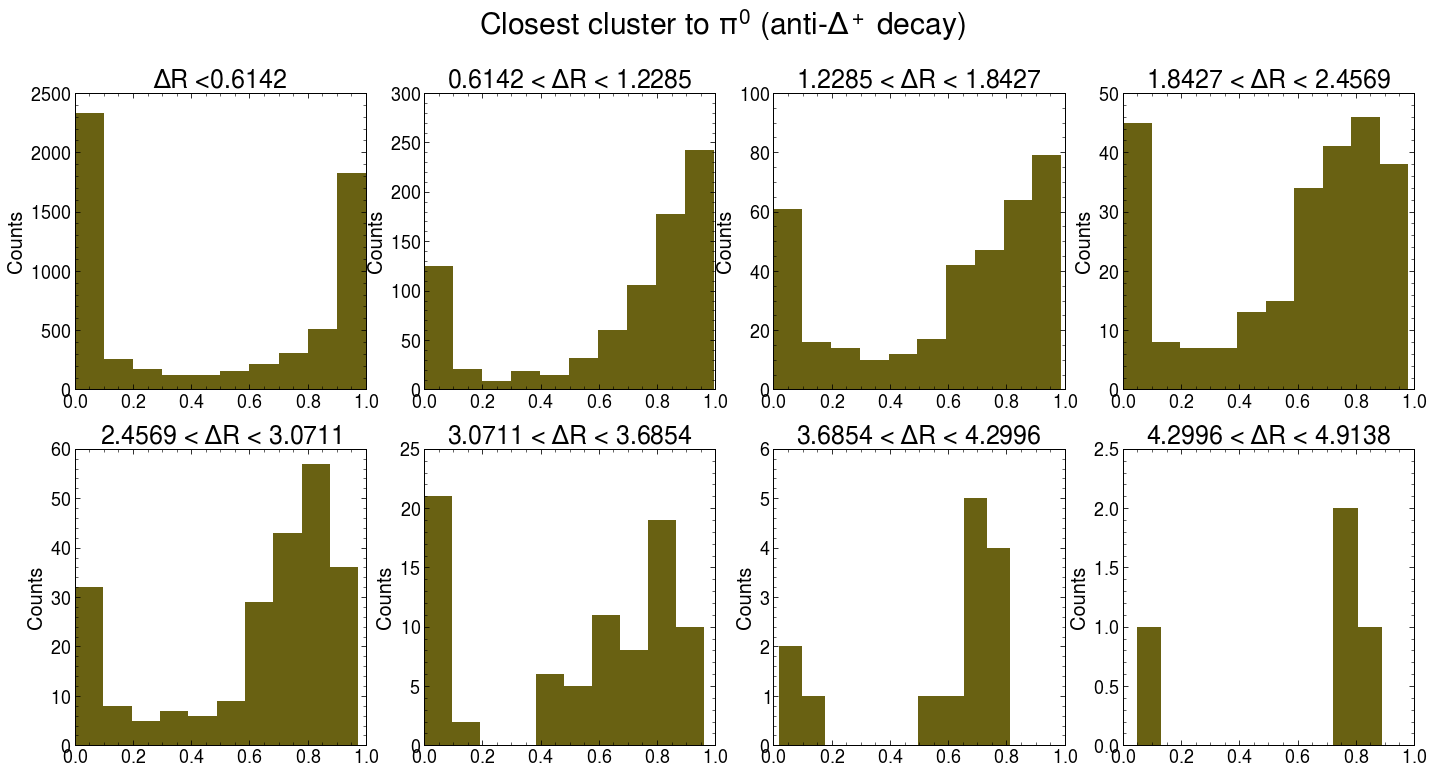

In [16]:
NNfileAdpp0 = np.load(model_path+'nn_closestcluster_Adelppi0.npz')
W.deltaR_responseplots(NNfileAdpp0, model_nog, col='xkcd:greenish brown', CC='Closest cluster to $\pi^0$ (anti-$\Delta^+$ decay)') #anti-delta+, no anti-ns, POI = pi0, also anti-ps

In [9]:
#try some to exclude the closest clusters if the cluster closest to the poi is also closest to the p/n/whatever

mask = makemask(truthID, 2214, 2112, 2212, 111) #delta+, no ns, POI = pi0, also ps

cs.doit_cc(mask, data_path+'w12_closestcluster_POIonly', 111, 2212)

#then do data processing:
file = np.load(data_path+'w12_closestcluster_POIonly.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster_POIonly.npz', len(X))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
8546
selec inds 8546
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster_POIonly


In [6]:
model_nog = tf.keras.models.load_model(model_path+'w8_pfn_noglob_2.hdf5')

(array([ 700.,  124.,   93.,   77.,   99.,  126.,  222.,  364.,  627.,
        1537.]),
 array([1.2879237e-10, 9.9967539e-02, 1.9993508e-01, 2.9990262e-01,
        3.9987016e-01, 4.9983770e-01, 5.9980524e-01, 6.9977278e-01,
        7.9974031e-01, 8.9970785e-01, 9.9967539e-01], dtype=float32),
 <BarContainer object of 10 artists>)

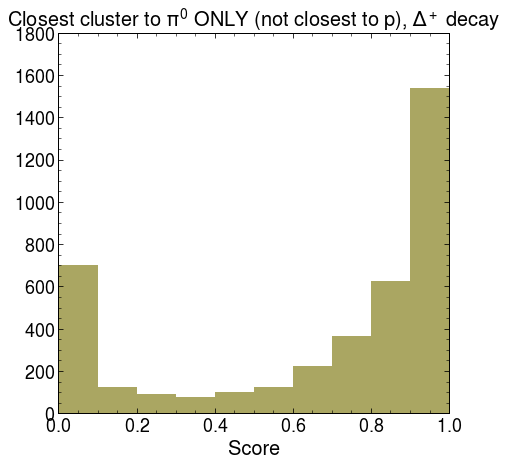

In [11]:
NNfile = np.load(model_path+'nn_closestcluster_POIonly.npz')

X_test = NNfile['arr_2']

preds = model_nog.predict(X_test, batch_size=100)

prob1, prob2 = preds.T #prob1 describes probability of it being a pi0, prob2 = probability of it being pipm!

plt.figure(figsize=[7,7])
plt.title('Closest cluster to $\pi^0$ ONLY (not closest to p), $\Delta^+$ decay')
plt.xlim(0,1)
plt.xlabel('Score')
plt.hist(prob1, color='xkcd:khaki')

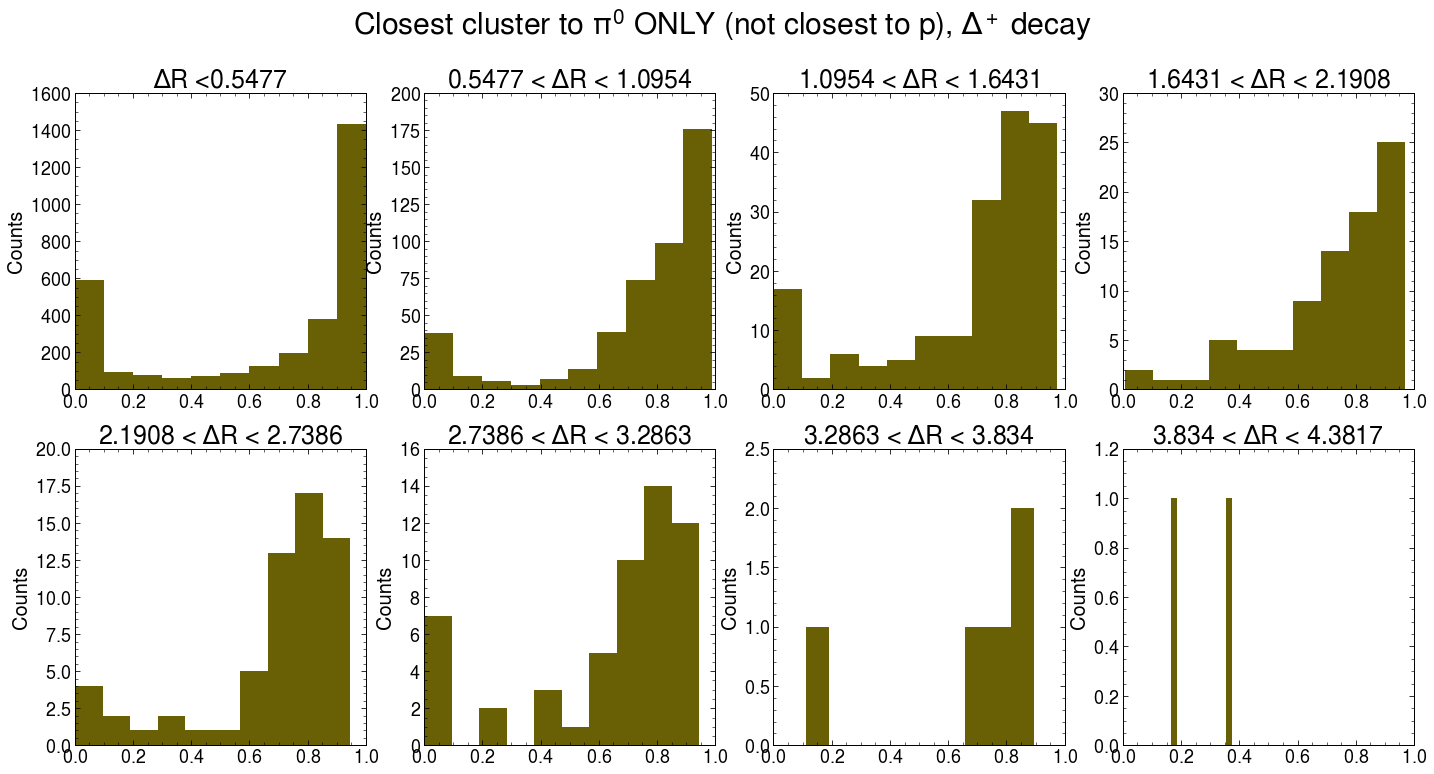

In [17]:
NNfile = np.load(model_path+'nn_closestcluster_POIonly.npz')
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:greeny brown', CC='Closest cluster to $\pi^0$ ONLY (not closest to p), $\Delta^+$ decay') #delta+, no ns, POI = pi0, also ps

In [9]:
mask = makemask(truthID, 2114, 2212, 2112, 111) #delta0, no ps, POI = pi0, also ns 

cs.doit_cc(mask, data_path+'w12_closestcluster_POIonly_d0p0', 111, 2112)

#then do data processing:
file = np.load(data_path+'w12_closestcluster_POIonly_d0p0.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster_POIonly_d0p0.npz', len(X))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
8549
selec inds 8549
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster_POIonly_d0p0


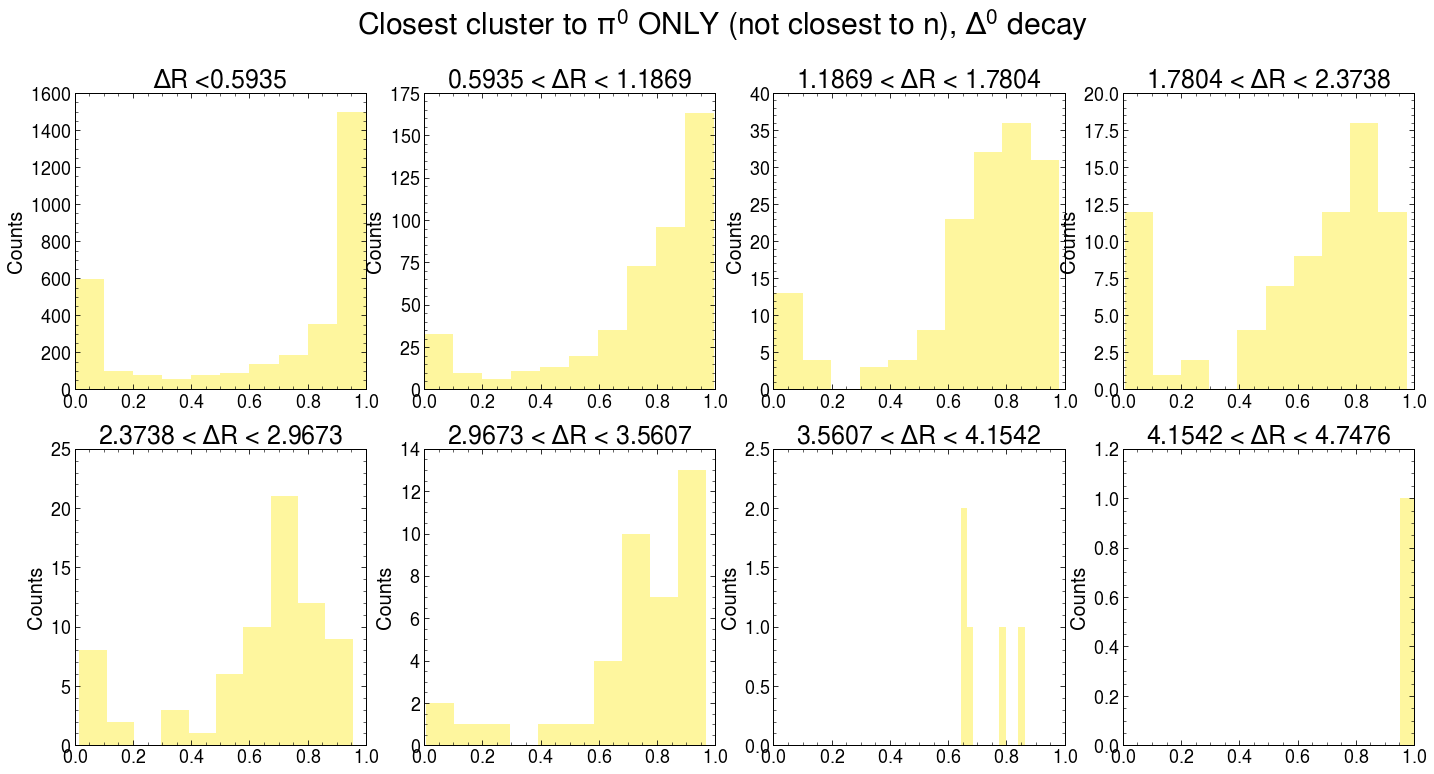

In [18]:
NNfile = np.load(model_path+'nn_closestcluster_POIonly_d0p0.npz')
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:buff', CC='Closest cluster to $\pi^0$ ONLY (not closest to n), $\Delta^0$ decay')

In [11]:
mask = makemask(truthID, -2114, -2212, -2112, 111) #anti-delta0, no anti-ps, POI = pi0, also anti-ns

cs.doit_cc(mask, data_path+'w12_closestcluster_POIonly_ad0p0', 111, -2112)

#then do data processing:
file = np.load(data_path+'w12_closestcluster_POIonly_ad0p0.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster_POIonly_ad0p0.npz', len(X))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
8869
selec inds 8869
Closest clusters found.
Normalizing
Writing out
Done! /data/atlas/w12_closestcluster_POIonly_ad0p0


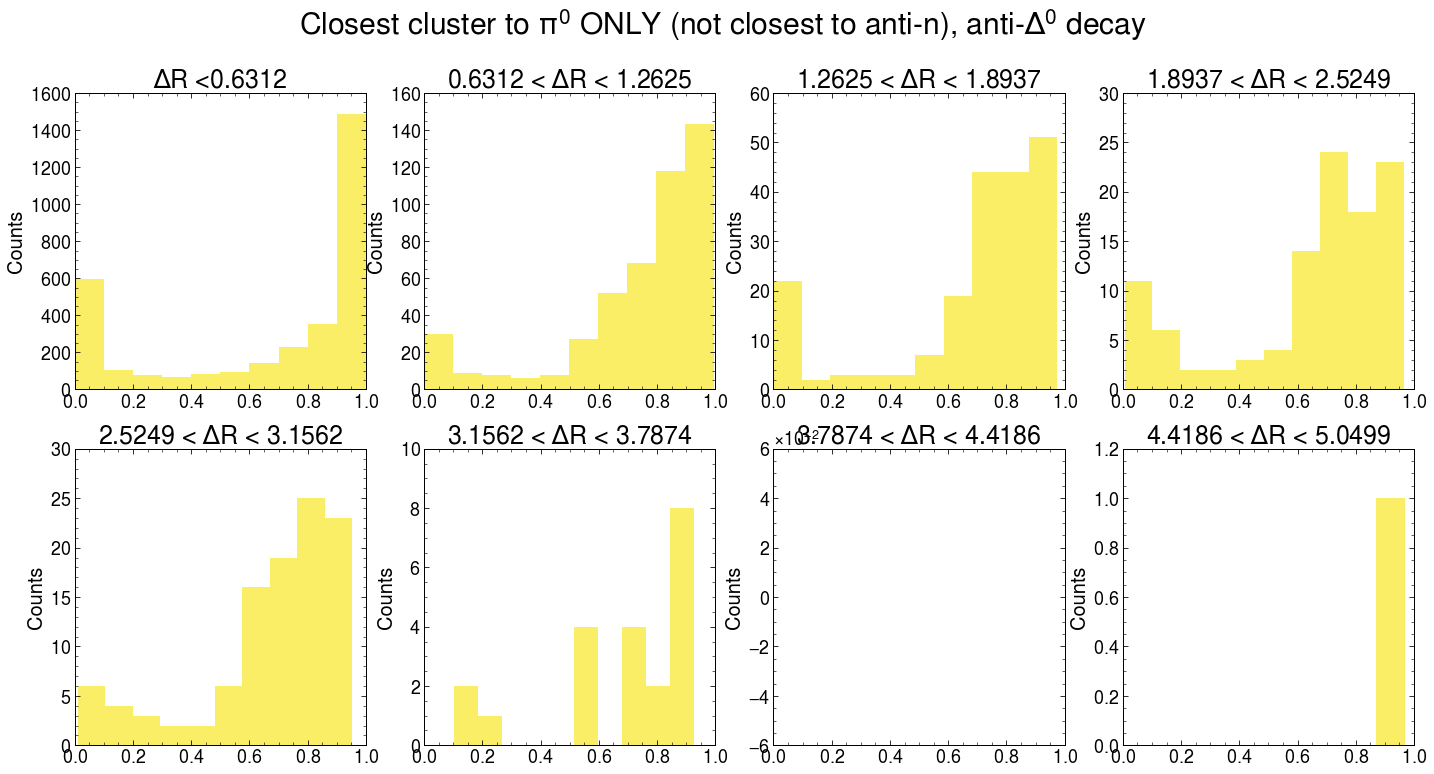

In [19]:
NNfile = np.load(model_path+'nn_closestcluster_POIonly_ad0p0.npz')
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:yellowish', CC='Closest cluster to $\pi^0$ ONLY (not closest to anti-n), anti-$\Delta^0$ decay')

In [20]:
mask = makemask(truthID, -2214, -2112, -2212, 111) #anti-delta+, no anti-ns, POI = pi0, also anti-ps

cs.doit_cc(mask, data_path+'w12_closestcluster_POIonly_adpp0', 111, -2212)

#then do data processing:
file = np.load(data_path+'w12_closestcluster_POIonly_adpp0.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster_POIonly_adpp0.npz', len(X))

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 111
8613
selec inds 8613
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster_POIonly_adpp0


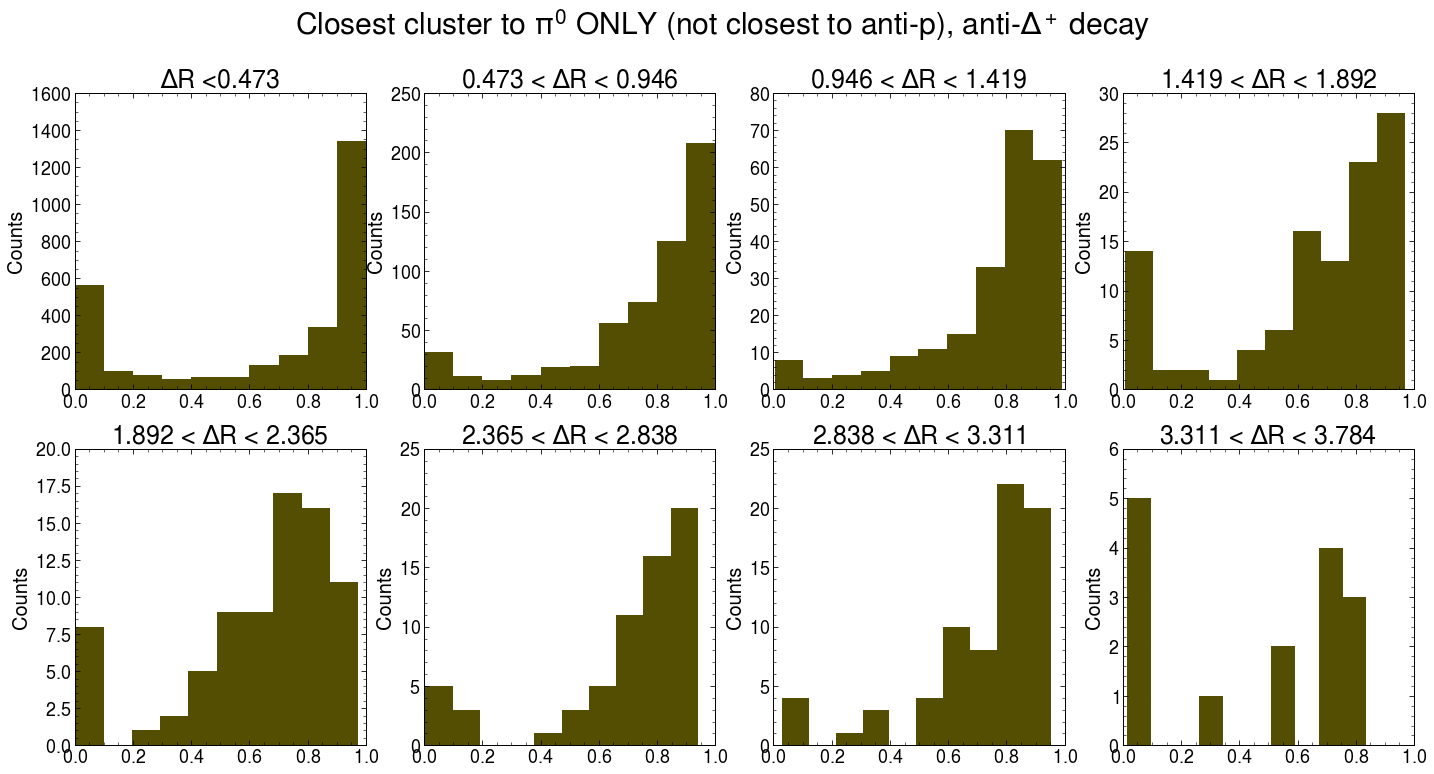

In [21]:
NNfile = np.load(model_path+'nn_closestcluster_POIonly_adpp0.npz')
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:green brown', CC='Closest cluster to $\pi^0$ ONLY (not closest to anti-p), anti-$\Delta^+$ decay')

In [14]:
#try one that selects closest to proton only, not pi0, delta+ decay:

mask = makemask(truthID, 2214, 2112, 111, 2212) #delta+, no ns, POI = pi0, also ps

cs.doit_cc(mask, data_path+'w16_closestcluster_p', 2212, 111)

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
Finding cluster closest to particle 2212
8546
selec inds 8546
Closest clusters found.
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:173: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w16_closestcluster_p


FileNotFoundError: [Errno 2] No such file or directory: '/data/atlas/w12_closestcluster_p.npz'

In [15]:
#then do data processing:
file = np.load(data_path+'w16_closestcluster_p.npz')

X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']

W.datatofile((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster_p.npz', len(X))

(array([2850.,  219.,  110.,   80.,   83.,   96.,  106.,  127.,  117.,
          97.]),
 array([1.1548800e-09, 9.9722520e-02, 1.9944504e-01, 2.9916754e-01,
        3.9889008e-01, 4.9861258e-01, 5.9833509e-01, 6.9805759e-01,
        7.9778016e-01, 8.9750266e-01, 9.9722517e-01], dtype=float32),
 <BarContainer object of 10 artists>)

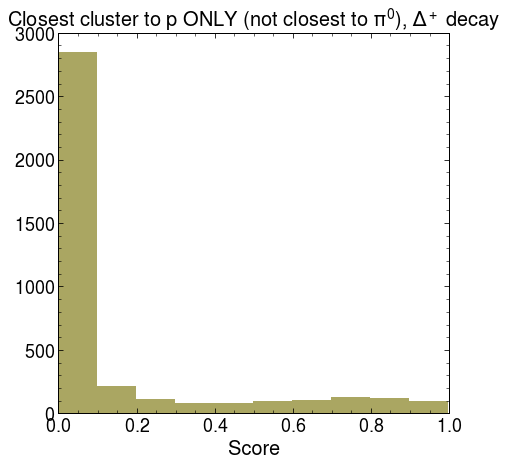

In [18]:
NNfile = np.load(model_path+'nn_closestcluster_p.npz')

X_test = NNfile['arr_2']

preds = model_nog.predict(X_test, batch_size=100)

prob1, prob2 = preds.T #prob1 describes probability of it being a pi0, prob2 = probability of it being pipm!

plt.figure(figsize=[7,7])
plt.title('Closest cluster to p ONLY (not closest to $\pi^0$), $\Delta^+$ decay')
plt.xlim(0,1)
plt.xlabel('Score')
plt.hist(prob1, color='xkcd:khaki')